In [8]:
import numpy as np
import pandas as pd
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm
import scipy
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import seaborn as sns
%matplotlib inline
#############
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
#######################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
#WBC Blood Cell Classification:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

## Original Data is unbalanced among different cell types (classes)

[  3  88  33  21 207]


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Counts')

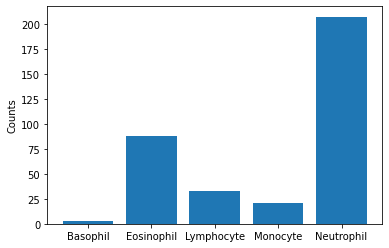

In [10]:
reader = csv.reader(open('data/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

## Augmented data (rotated, zoom-in + zoom-out, random crop, etc.) to make it balanced

In [ ]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
#                     img_file = Image.fromarray(img_file).resize(size=(60,80,3))
#                     img_file = resize(img_file, (60,80,3)) #reduce the size of the picture
                    img_file = resize(img_file, (120,160,3)) #reduce the size of the picture
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

X_train, y_train, z_train = get_data('data/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('data/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(dict_characters)
print(dict_characters2)

100%|██████████████████████████████████████████████████████████████████████████████| 2499/2499 [01:40<00:00, 24.85it/s]


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


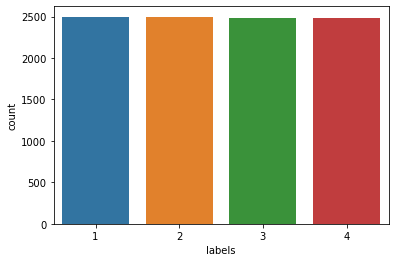

In [59]:
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [41]:
# # Covert Augmented Data to Torch
# X_train_torch = torch.from_numpy(X_train)
# X_train_torch = X_train_torch.reshape((X_train_torch.shape[0], 3,X_train_torch.shape[1],X_train_torch.shape[2]))
# y_train_torch = torch.from_numpy(y_train-1)
# z_train_torch = torch.from_numpy(z_train)

# X_test_torch = torch.from_numpy(X_test)
# X_test_torch = X_test_torch.reshape((X_test_torch.shape[0],3,X_test_torch.shape[1],X_test_torch.shape[2]))
# y_test_torch = torch.from_numpy(y_test-1)
# z_test_torch = torch.from_numpy(z_test)

# trainset_y = TensorDataset(X_train_torch, y_train_torch)
# trainset_z = TensorDataset(X_train_torch, z_train_torch)
# testset_y = TensorDataset(X_test_torch, y_test_torch)
# testset_z = TensorDataset(X_test_torch, z_test_torch)

# #Torch Data Loader:
# train_minibatch_size = 64
# test_minibatch_size = 128
# train_loader = DataLoader(trainset_y, batch_size = train_minibatch_size, shuffle = True)
# test_loader = DataLoader(testset_y, batch_size = test_minibatch_size, shuffle = True)

In [62]:
class BloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        return self.images[idx], self.labels[idx]

In [65]:
tfms = transforms.Compose([transforms.ToTensor()])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#normalize the input data
mean = tuple((X_train.mean(axis=(0,1,2))/255).round(4))
std = tuple((X_train.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean, std)])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#####################################
tfms = transforms.Compose([transforms.ToTensor()])
test = BloodDataset(X_test, y_test-1, transform=tfms)
mean = tuple((X_test.std(axis=(0,1,2))/255).round(4))
std = tuple((X_test.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean, std)])
test = BloodDataset(X_test, y_test-1, transform=tfms)
##################################
batch_size = 128
test_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=test_size, shuffle=True)

# Task2 : Classification of different cell types

In [68]:
#Train Function:
def train(epoch, model, train_loader):
    model.train()
    
    train_nb_batch = len(train_loader)
    train_loss = 0.0
    train_batch_loss = 0.0
    train_total_loss = 0.0
    train_acc = 0.0
    train_batch_acc = 0.0
    train_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(train_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        #zero that gradients buffer
        optimizer.zero_grad()
        #forward + backward + optimize
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        loss.backward()
        optimizer.step()

        train_batch_loss = loss.item()
        train_total_loss += train_batch_loss
        pred_batch_train = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_train = pred_batch_train
        if i >0:
            pred_train = torch.cat([pred_train, pred_batch_train], dim=0)
        train_batch_acc = accuracy_score(pred_batch_train,minibatch_y)
        train_total_acc += train_batch_acc
        
    train_loss = train_total_loss/train_nb_batch
    train_acc = train_total_acc/train_nb_batch
    scheduler.step()
    return pred_train, train_loss, train_acc

In [69]:
def test(epoch, model, test_loader):
    model.eval()
    
    test_nb_batch = len(test_loader)
    test_loss = 0.0
    test_batch_loss = 0.0
    test_total_loss = 0.0
    test_acc = 0.0
    test_batch_acc = 0.0
    test_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(test_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        test_batch_loss = loss.item()
        test_total_loss += test_batch_loss
        pred_batch_test = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_test = pred_batch_test
        if i >0:
            pred_test = torch.cat([pred_test, pred_batch_test], dim=0)
        test_batch_acc = accuracy_score(pred_batch_test,minibatch_y)
        test_total_acc += test_batch_acc
    test_loss = test_total_loss/test_nb_batch
    test_acc = test_total_acc/test_nb_batch
    return pred_test, test_loss, test_acc

### VGG16:

In [95]:
n_classes = 4
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(num_ftrs, 128),  
                nn.ReLU(), 
                nn.Dropout(0.2),
                nn.Linear(128, 32),
                nn.Linear(32, 4))
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.01, amsgrad=False)
lr = 0.0001
optimizer = optim.Adam(vgg16.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=[10,20,30,40,60,80], gamma=0.5)

In [96]:
num_epoch = 100
train_losses = []
test_losses = []
train_accs = []
test_accs= []

for epoch in range(num_epoch):
    pred_train, train_loss, train_acc = train(epoch, vgg16, train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    pred_test, test_loss, test_acc = test(epoch, vgg16, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print("epoch:",epoch,"train loss:", train_loss, "train accuracy:", train_acc)
    print("epoch:",epoch,"test loss:", test_loss, "test accuracy:", test_acc)

epoch: 0 train loss: 2.4047946700683007 train accuracy: 0.26789695195481084
epoch: 0 test loss: 1.3854823231697082 test accuracy: 0.26156250000000003
epoch: 1 train loss: 1.4064680674137213 train accuracy: 0.2679038937547601
epoch: 1 test loss: 1.3883894085884094 test accuracy: 0.25400568181818184
epoch: 2 train loss: 1.3981568996722882 train accuracy: 0.2734127078573242
epoch: 2 test loss: 1.3820742785930633 test accuracy: 0.2765269886363636
epoch: 3 train loss: 1.3873829520665681 train accuracy: 0.2797961887534907
epoch: 3 test loss: 1.3718047916889191 test accuracy: 0.33433948863636365
epoch: 4 train loss: 1.383821313197796 train accuracy: 0.27756588759837525
epoch: 4 test loss: 1.3673416256904602 test accuracy: 0.35854403409090907
epoch: 5 train loss: 1.3735139018450029 train accuracy: 0.2980065133917238
epoch: 5 test loss: 1.3620157122612 test accuracy: 0.37196022727272726
epoch: 6 train loss: 1.37082094565416 train accuracy: 0.2959487655496319
epoch: 6 test loss: 1.35992623567581

epoch: 56 train loss: 1.1470633791043208 train accuracy: 0.48204156353135313
epoch: 56 test loss: 1.2297059655189515 test accuracy: 0.43901278409090916
epoch: 57 train loss: 1.1376602833087628 train accuracy: 0.48505926313785225
epoch: 57 test loss: 1.2322844326496125 test accuracy: 0.4349715909090909
epoch: 58 train loss: 1.1343737489137895 train accuracy: 0.487636654290429
epoch: 58 test loss: 1.2280932724475861 test accuracy: 0.43901278409090916
epoch: 59 train loss: 1.1457305795107133 train accuracy: 0.485513455191673
epoch: 59 test loss: 1.2341805279254914 test accuracy: 0.44109375
epoch: 60 train loss: 1.1372713461900368 train accuracy: 0.4903072638994668
epoch: 60 test loss: 1.2297048389911651 test accuracy: 0.44161931818181815
epoch: 61 train loss: 1.1298977396427057 train accuracy: 0.49261789159685204
epoch: 61 test loss: 1.2298285782337188 test accuracy: 0.44225852272727273
epoch: 62 train loss: 1.1315708305591192 train accuracy: 0.48917277545062193
epoch: 62 test loss: 1.229

In [49]:
print('Finished Training')
PATH = './Project_Task2_VGG16_100epoch_lr0001_dropout.pkl'
torch.save(model, PATH)

Finished Training


In [50]:
np.save('train_losses_VGG16_100epoch_dropout.npy', train_losses)
np.save('train_errors_VGG16_100epoch_dropout.npy', train_errors)
np.save('test_losses_VGG16_100epoch_dropout.npy', test_losses)
np.save('test_errors_VGG16_100epoch_dropout.npy', test_errors)

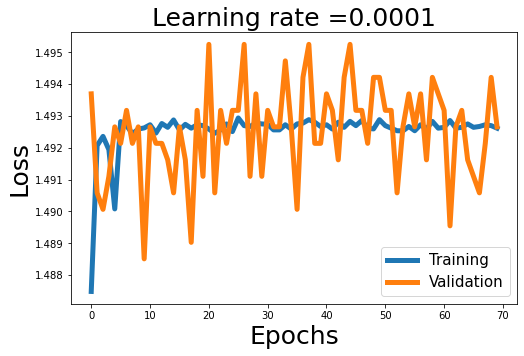

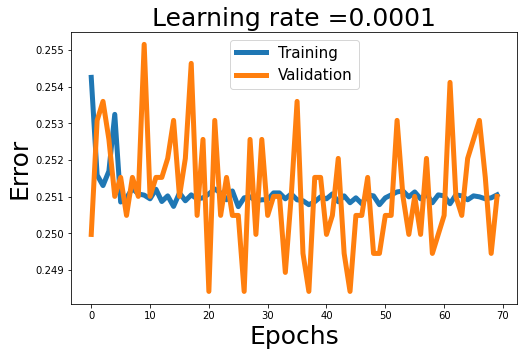

In [92]:
#Plot Train and Validation Loss 
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_losses[:])),train_losses[:], label='Training', linewidth=5)
plt.plot(np.arange(len(test_losses[:])),test_losses[:], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Loss',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_VGG16_loss.png')
plt.show() 

#Plot Train and Validation Errors
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_accs[:])),train_accs[:], label='Training', linewidth=5)
plt.plot(np.arange(len(test_accs[:])),test_accs[:], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Error',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_VGG16_error.png')
plt.show() 